In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix

In [2]:
from mochi import f_beta_01,runLGBM,check_feature_importance

In [3]:
class Config:
    pass
config = pd.read_pickle('config.pkl')
data_path = config.data_path
feature_path = config.feature_path
print(dir(config))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'data_path', 'feature_dict', 'feature_path', 'model_features', 'result_path', 'single_module_validation_indice_set', 'trade_train_size', 'train_2_6_index']


In [4]:
config.feature_dict.keys()

dict_keys(['trade_and_recent_login_comparing', 'recent_login_detail', 'trade_detail_feature', 'login_trade_hist_stats', 'llc_user_habbit', 'hcc_user_habbit'])

In [5]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
              config.feature_dict['hcc_user_habbit'] 
             )
feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)

In [6]:
validation_tuple_list = config.single_module_validation_indice_set
train_labels = pd.read_pickle(data_path+'trade_train_label.pkl')

### Validation

In [9]:
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.957468	test's auc: 0.940344
[200]	train's auc: 0.98396	test's auc: 0.967108
[300]	train's auc: 0.993427	test's auc: 0.970701
[400]	train's auc: 0.998044	test's auc: 0.971128
[500]	train's auc: 0.999273	test's auc: 0.971324
Early stopping, best iteration is:
[440]	train's auc: 0.998809	test's auc: 0.971873
f_beta score for the turn 1 is 0.846242980658
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.970805	test's auc: 0.870826
[200]	train's auc: 0.988744	test's auc: 0.907683
[300]	train's auc: 0.996786	test's auc: 0.920903
[400]	train's auc: 0.999025	test's auc: 0.927863
[500]	train's auc: 0.999583	test's auc: 0.929458
Early stopping, best iteration is:
[495]	train's auc: 0.999569	test's auc: 0.930265
f_beta score for the turn 2 is 0.625817555938
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.967107	test's auc: 0.921907
[200]	train's

In [14]:
sorted_feature_importacne = check_feature_importance(models,features)
sorted_feature_importacne

[('login_distance_0', 50617.308864304301),
 ('device_repeat_count_360', 25013.209751710318),
 ('trade_login_success_rate_1', 18313.601540686439),
 ('trade_times_1', 17472.237796712419),
 ('timelong_std_1', 16713.191089977274),
 ('login_success_rate_360', 13801.899415225878),
 ('trade_login_rate_1', 12771.73038998158),
 ('period_3_trade_rate_360', 12011.6099521095),
 ('type_3_count_30', 11595.463593693925),
 ('fail_-2_rate_30', 11264.889468047655),
 ('period_4_login_rate_30', 11111.170050848012),
 ('login_distance_1', 10755.221894934135),
 ('period_4_login_rate_360', 10204.219240641705),
 ('type_login_0', 10059.904663524971),
 ('timelong_max_1', 9413.0348351903103),
 ('timelong_min_30', 7433.3800192495964),
 ('type_3_rate_30', 7097.833468622578),
 ('period_3_login_rate_360', 7008.1927251108245),
 ('timelong_min_15', 6234.9106503848625),
 ('city_used_count_30', 6230.8526970412731),
 ('city_most_freq_rate_360', 5789.453926397332),
 ('success_1_rate_30', 5637.2196348337657),
 ('city_login_

<Container object of 331 artists>

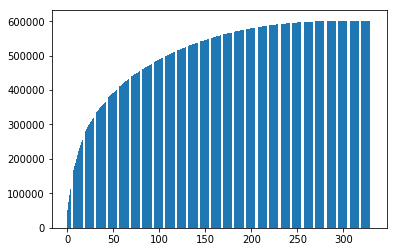

In [13]:
%matplotlib inline
all_importance = [x[1] for x in sorted_feature_importacne]
x = pd.Series(all_importance).sort_values(ascending = False).cumsum()
plt.bar(range(len(x)),x)

考虑在230左右截断

In [19]:
top_features =  [x[0] for x in sorted_feature_importacne][0:150]
top_features_ori_index = [features.index(x) for x in top_features]
trade_tt_top = trade_tt_mat[:,top_features_ori_index]

In [20]:
#top 150 features
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_top[train_indice], trade_tt_top[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.959636	test's auc: 0.943217
[200]	train's auc: 0.983199	test's auc: 0.966267
[300]	train's auc: 0.993452	test's auc: 0.972066
[400]	train's auc: 0.997552	test's auc: 0.971752
Early stopping, best iteration is:
[331]	train's auc: 0.995611	test's auc: 0.972568
f_beta score for the turn 1 is 0.833669258086
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.971634	test's auc: 0.869022
[200]	train's auc: 0.9892	test's auc: 0.906805
[300]	train's auc: 0.996495	test's auc: 0.92045
[400]	train's auc: 0.998821	test's auc: 0.92674
[500]	train's auc: 0.999533	test's auc: 0.928603
[600]	train's auc: 0.999822	test's auc: 0.928396
[700]	train's auc: 0.999942	test's auc: 0.929227
Early stopping, best iteration is:
[646]	train's auc: 0.9999	test's auc: 0.929845
f_beta score for the turn 2 is 0.504258443465
Training until validation scores don't improve for 100 rounds.
[100]	train's auc:

### other parameteres and lower the learning rate

In [32]:
cv_scores = []
cv_result = []
models = []
confusion_list = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.01,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None,
                          bagging_fraction =0.75,feature_fraction =0.75,num_leaves=16)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.8, 0.1)
    
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    confusion_list.append(confusion_matrix(val_y,preds > 0.8))
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.94352	test's auc: 0.917722
[200]	train's auc: 0.963162	test's auc: 0.946521
[300]	train's auc: 0.97537	test's auc: 0.959714
[400]	train's auc: 0.98381	test's auc: 0.967939
[500]	train's auc: 0.989392	test's auc: 0.969742
[600]	train's auc: 0.994014	test's auc: 0.970938
[700]	train's auc: 0.996781	test's auc: 0.971801
Early stopping, best iteration is:
[654]	train's auc: 0.996045	test's auc: 0.97202
f_beta score for the turn 1 is 0.901224320398
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.950561	test's auc: 0.832348
[200]	train's auc: 0.972477	test's auc: 0.87859
[300]	train's auc: 0.981752	test's auc: 0.896803
[400]	train's auc: 0.990377	test's auc: 0.905838
[500]	train's auc: 0.994034	test's auc: 0.91464
[600]	train's auc: 0.996594	test's auc: 0.923282
[700]	train's auc: 0.998464	test's auc: 0.925804
[800]	train's auc: 0.999043	test's auc: 0.927881
[900]	train's a

In [33]:
confusion_total = np.zeros([2,2])
for confusion in confusion_list:
    confusion_total += confusion
confusion_total

array([[  4.64330000e+04,   2.00000000e+01],
       [  8.05000000e+02,   1.73000000e+02]])

In [36]:
import lightgbm as lgb

In [34]:
def runLGBM(train_X, train_y, test_X, test_y=None, feature_names=None,
           seed_val=0, num_rounds=10000,watch_dict = None,max_bin=50000,
           num_leaves=16,early_stop=64,verbose=True,eta=0.1,
           bagging_fraction = 0.75 , feature_fraction = 0.75,feval = None,metric = 'binary_logloss',
           train_sample_weight = None,is_unbalance = False):
    
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': num_leaves,
        'learning_rate': eta,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': 5,
        'verbose': verbose,
        'is_unbalance':is_unbalance
    }
    
    num_rounds = num_rounds

    #plst = list(param.items())
    lgbtrain = lgb.Dataset(train_X, label=train_y,max_bin=max_bin,feature_name=feature_names,weight =train_sample_weight)

    if test_y is not None:
        lgbtest = lgb.Dataset(test_X, label=test_y,max_bin=max_bin,feature_name=feature_names)
        watchlist = [lgbtrain,lgbtest]
        watchlist_name=['train','test']
        model = lgb.train(params, lgbtrain, num_rounds, watchlist,watchlist_name, early_stopping_rounds=early_stop,\
                         evals_result = watch_dict,verbose_eval=verbose,feval = feval)
    else:
        #lgbtest = lgb.Dataset(test_X,feature_name=feature_names)
        model = lgb.train(params, lgbtrain, num_rounds)

    pred_test_y = model.predict(test_X)
    return pred_test_y, model

In [104]:
cv_scores = []
cv_result = []
models = []
confusion_list = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.01,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None,
                          bagging_fraction =0.75,feature_fraction =0.75,num_leaves=16,is_unbalance=True)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.9, 0.1)
    
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    confusion_list.append(confusion_matrix(val_y,preds > 0.9))
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.977409	test's auc: 0.96219
[200]	train's auc: 0.985875	test's auc: 0.968413
[300]	train's auc: 0.991127	test's auc: 0.971234
[400]	train's auc: 0.993917	test's auc: 0.972328
[500]	train's auc: 0.995732	test's auc: 0.972429
[600]	train's auc: 0.997002	test's auc: 0.972401
Early stopping, best iteration is:
[548]	train's auc: 0.996437	test's auc: 0.972764
f_beta score for the turn 1 is 0.819871742836
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.984808	test's auc: 0.894708
[200]	train's auc: 0.990134	test's auc: 0.90963
[300]	train's auc: 0.99357	test's auc: 0.915297
[400]	train's auc: 0.995584	test's auc: 0.918362
[500]	train's auc: 0.996749	test's auc: 0.923141
[600]	train's auc: 0.997581	test's auc: 0.925181
[700]	train's auc: 0.998229	test's auc: 0.927928
[800]	train's auc: 0.998664	test's auc: 0.928014
[900]	train's auc: 0.999022	test's auc: 0.929095
Early stoppi

In [107]:
confusion_total = np.zeros([2,2])
for confusion in confusion_list:
    confusion_total += confusion
confusion_total

array([[ 46333.,    120.],
       [   626.,    352.]])

### Try resampling

In [100]:
def resample(train_set,labels):
    false_set = train_set[labels==0]
    true_set = train_set[labels==1]
    true_set_size = true_set.shape[0]
    #print(len(false_set))
    new_false_set = false_set[np.random.choice(list(range(len(false_set))),size = 4*true_set_size)]
    
    new_train_set = np.vstack([true_set,true_set,new_false_set])
    new_train_label = np.hstack([np.ones(true_set_size,dtype=np.int),np.ones(true_set_size,dtype=np.int),np.zeros(4*true_set_size,dtype=np.int)])
    
    shuffle_index = list(range(new_train_set.shape[0]))
    np.random.shuffle(shuffle_index)
    
    new_train_set = new_train_set[shuffle_index]
    new_train_label = new_train_label[shuffle_index]

    return new_train_set,new_train_label

In [103]:
cv_scores = []
cv_result = []
models = []
confusion_list = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, dev_y = resample(trade_tt_mat[train_indice],train_labels.iloc[train_indice].values)
    val_X = trade_tt_mat[val_indice]
    val_y = train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.01,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None,
                          bagging_fraction =0.75,feature_fraction =0.75,num_leaves=16)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.8, 0.1)
    
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    confusion_list.append(confusion_matrix(val_y,preds > 0.8))
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.974412	test's auc: 0.955658
[200]	train's auc: 0.984142	test's auc: 0.964219
[300]	train's auc: 0.99107	test's auc: 0.968393
[400]	train's auc: 0.995168	test's auc: 0.969616
[500]	train's auc: 0.997399	test's auc: 0.970394
[600]	train's auc: 0.998644	test's auc: 0.969404
Early stopping, best iteration is:
[518]	train's auc: 0.997717	test's auc: 0.97046
f_beta score for the turn 1 is 0.741724715157
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.982369	test's auc: 0.886415
[200]	train's auc: 0.989708	test's auc: 0.903956
[300]	train's auc: 0.993909	test's auc: 0.909953
[400]	train's auc: 0.996598	test's auc: 0.915625
[500]	train's auc: 0.998264	test's auc: 0.918718
[600]	train's auc: 0.999156	test's auc: 0.922194
[700]	train's auc: 0.999618	test's auc: 0.924341
[800]	train's auc: 0.999836	test's auc: 0.925566
[900]	train's auc: 0.999935	test's auc: 0.926659
[1000]	trai

In [102]:
confusion_total = np.zeros([2,2])
for confusion in confusion_list:
    confusion_total += confusion
confusion_total

array([[ 45358.,   1095.],
       [   314.,    664.]])